## **Previsão de Vendas - LSTM Multi-features**

Instituto Mauá de Tecnologia

Giovanni Schiffini

<p>Este Trabalho tem como objetivo modelar um problema e realizar predições utilizando uma rede LSTM. Optou-se por dividir os dados de vendas anteriores em intervalos de um dia, pois se os dados fossem colhidos mensalmente, um mês em específico apareceria poucas vezes no dataset, gerando um extremo overfitting.</p>

O dataset utilizado é este: [Kaggle - Predict Future Sales](https://www.kaggle.com/c/competitive-data-science-predict-future-sales/data)

# **Preparação dos dados**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import missingno as msno

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Carregar os dados sales_train 
sales_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/sales_train.csv',parse_dates=True)
sales_train.head()


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


Esta é a tabela original. A data está em formato dd/mm/aaaa. Este formato não nos atende para ordenar os itens ao longo do tempo.

In [ ]:
print(sales_train.columns)

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')


In [ ]:
sales_train['date']= pd.to_datetime(sales_train['date'],format = '%d.%m.%Y')
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


Tabela reordenada para o formato de data mais adequado.

In [ ]:
sales_train.sort_values(by='date',inplace=True)
sales_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
49800,2013-01-01,0,18,5823,2500.0,1.0
29784,2013-01-01,0,27,5573,849.0,1.0
35476,2013-01-01,0,7,1006,399.0,1.0
8330,2013-01-01,0,19,17707,899.0,1.0
57384,2013-01-01,0,14,19548,149.0,1.0
...,...,...,...,...,...,...
2885098,2015-10-31,33,41,21386,169.0,1.0
2930981,2015-10-31,33,21,988,199.0,1.0
2885097,2015-10-31,33,41,21377,169.0,1.0
2930993,2015-10-31,33,22,10207,1199.0,1.0


date - data em formato aaaa/mm/dd

date_block_num - um índice consecutivo para os meses, desde Jan/2013 - 0 até Out/2015 - 33.

shop_id - identificador único para cada shop (loja).

item_id - identificador único para cada produto.

item_price - preço atual do item.

item_cnt_day - quantidade de produtos vendidos.

In [ ]:
sales = sales_train.iloc[:,0:6]
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
49800,2013-01-01,0,18,5823,2500.0,1.0
29784,2013-01-01,0,27,5573,849.0,1.0
35476,2013-01-01,0,7,1006,399.0,1.0
8330,2013-01-01,0,19,17707,899.0,1.0
57384,2013-01-01,0,14,19548,149.0,1.0


In [ ]:
profit = {'profit_per_sale':sales['item_cnt_day']*sales['item_price']}
profit_per_sale = pd.DataFrame(data = profit)
sales = pd.concat([sales,profit_per_sale],axis=1,)
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,profit_per_sale
49800,2013-01-01,0,18,5823,2500.0,1.0,2500.0
29784,2013-01-01,0,27,5573,849.0,1.0,849.0
35476,2013-01-01,0,7,1006,399.0,1.0,399.0
8330,2013-01-01,0,19,17707,899.0,1.0,899.0
57384,2013-01-01,0,14,19548,149.0,1.0,149.0


profit_per_sale (faturamento bruto) = qtde itens vendidos no dia multiplicado pelo preço atual do item.

A seguir, verificações de integridade dos dados:

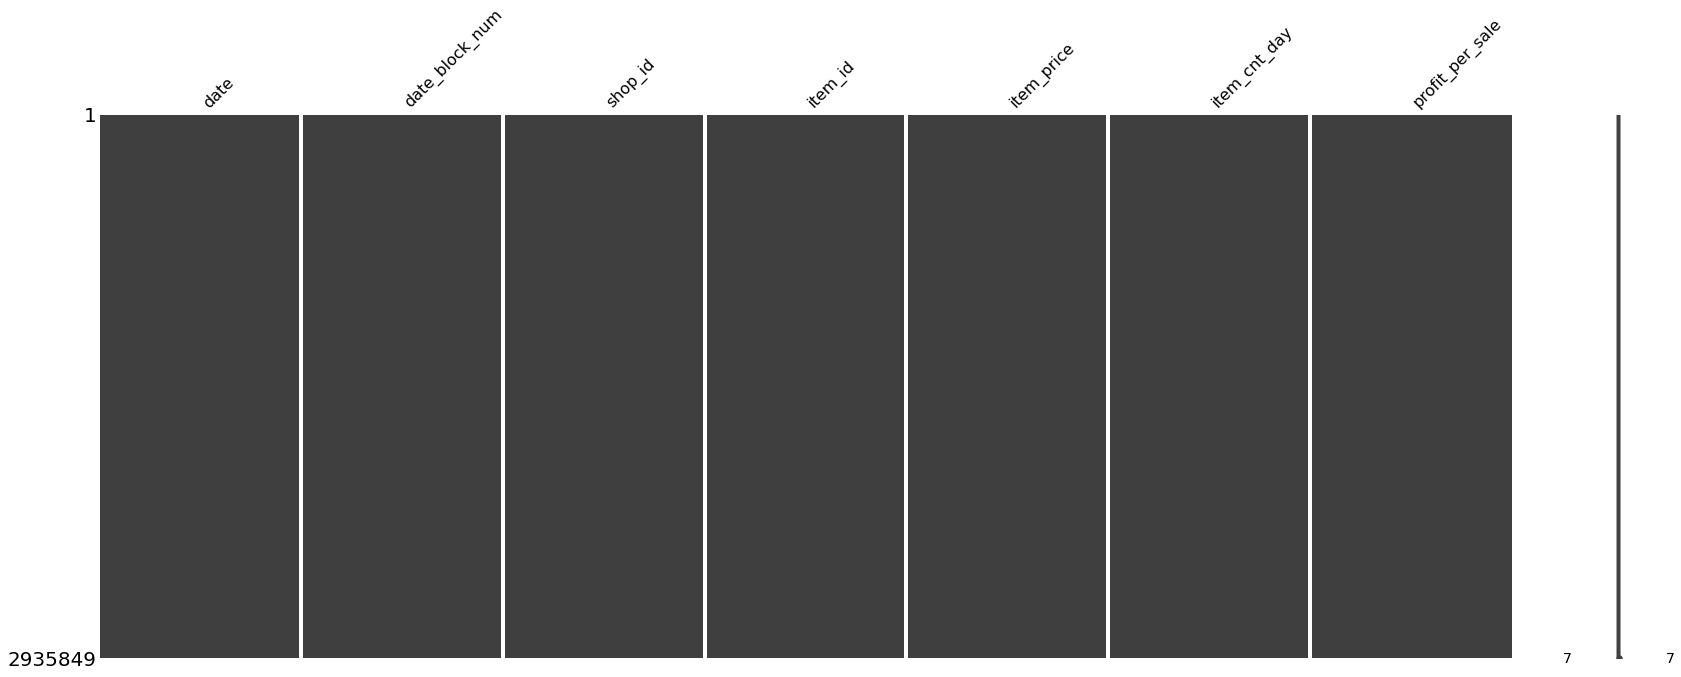

In [ ]:
msno.matrix(sales)

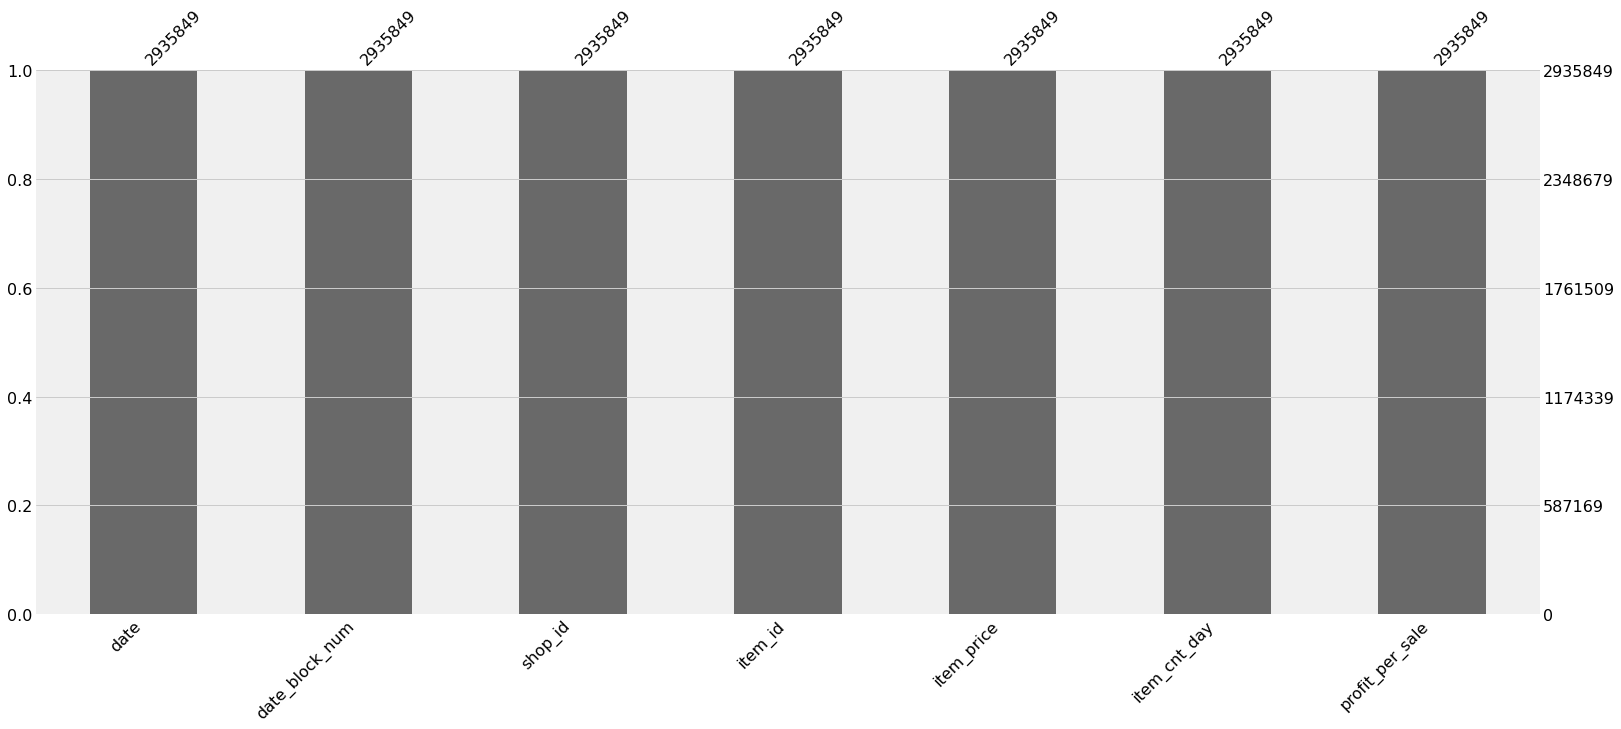

In [ ]:
msno.bar(sales)

In [ ]:
shop_id_number = sales.iloc[:,1].unique()
print(np.sort(shop_id_number))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]


In [ ]:
item_id = sales.iloc[:,2].unique()
print(np.sort(item_id))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]


In [ ]:
item_count_day = sales.iloc[:,4].unique()
print(np.sort(item_count_day))

[-1.0000e+00  7.0000e-02  8.7500e-02 ...  5.0999e+04  5.9200e+04
  3.0798e+05]


In [ ]:
sales['item_cnt_day'] = np.where(sales.item_cnt_day < 0,float("NaN"),sales.item_cnt_day)


Versão do item_count_day sem valores negativos (variações de estoque e etc):

In [ ]:
item_count_day = sales.iloc[:,4].unique()
print(np.sort(item_count_day))

[-1.0000e+00  7.0000e-02  8.7500e-02 ...  5.0999e+04  5.9200e+04
  3.0798e+05]


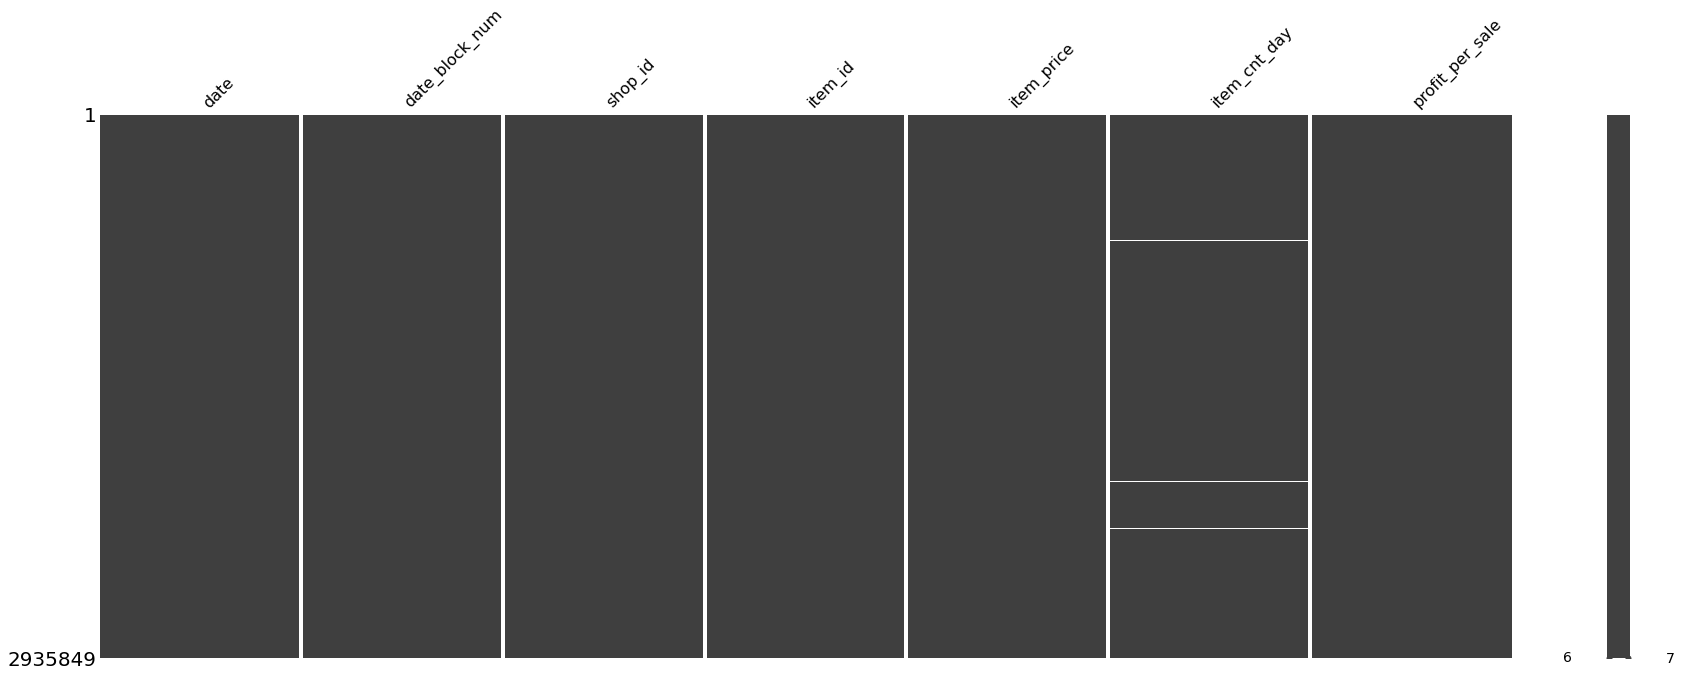

In [ ]:
msno.matrix(sales)

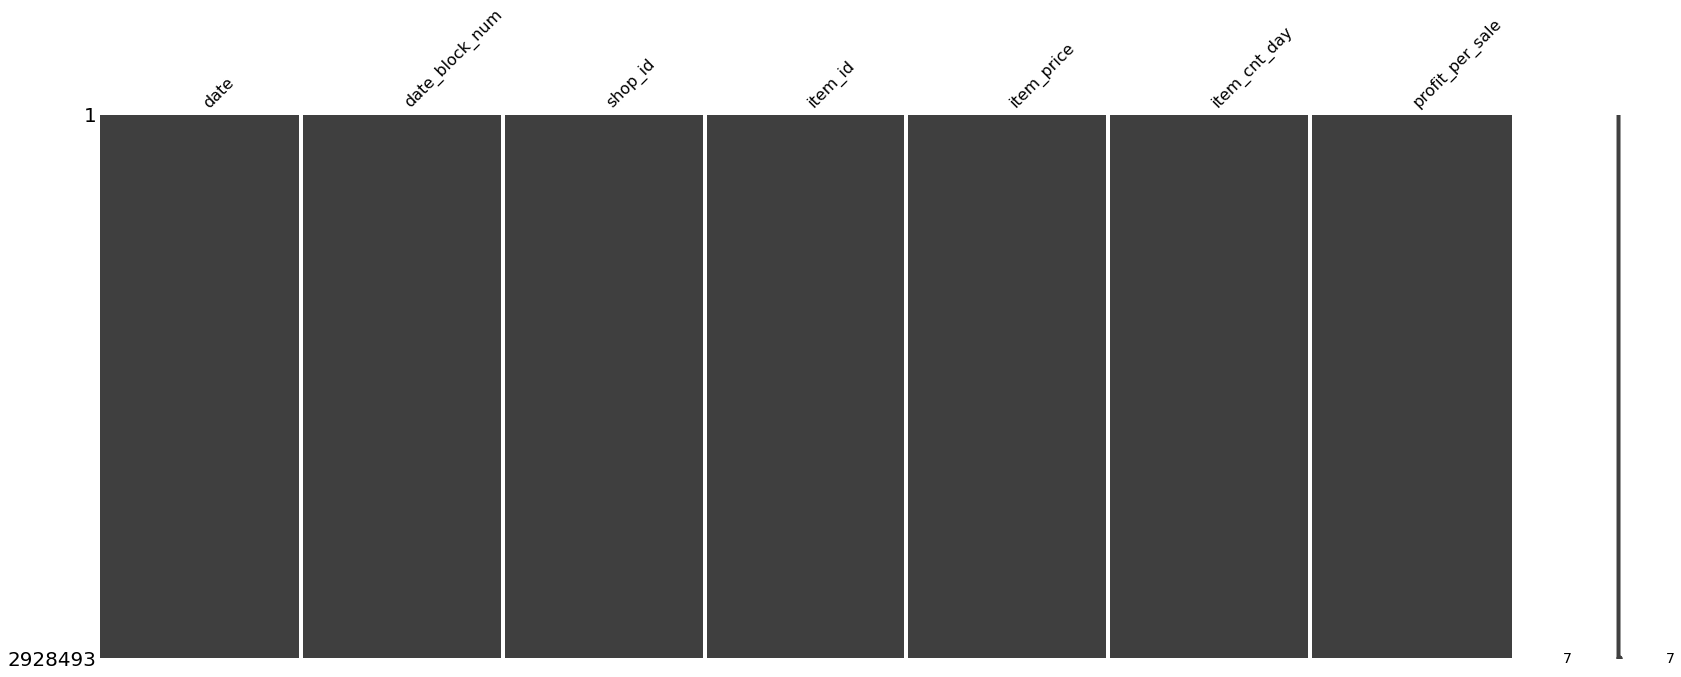

In [ ]:
sales.dropna(inplace=True)
msno.matrix(sales)

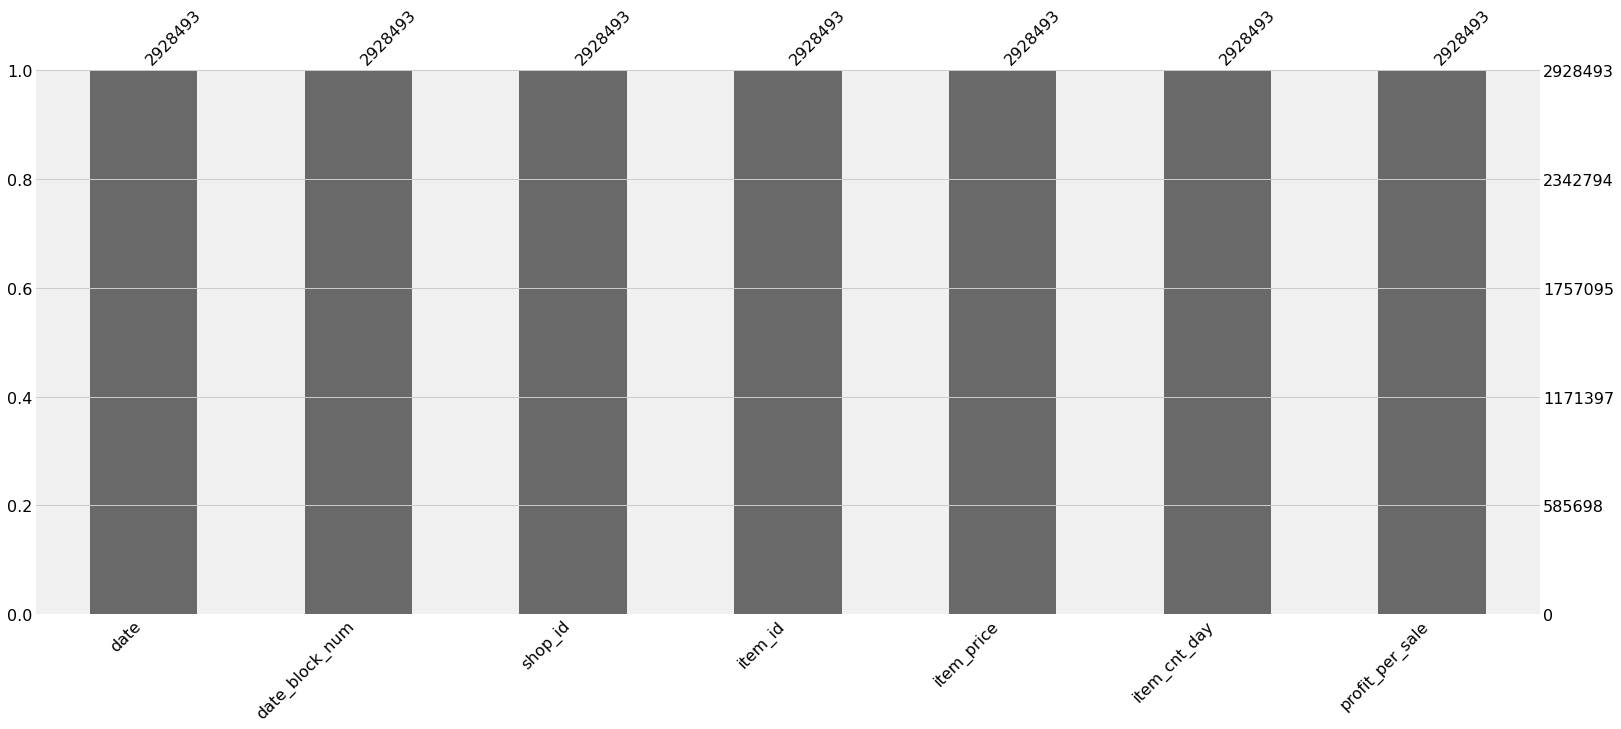

In [ ]:
msno.bar(sales)

In [ ]:
sales.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'profit_per_sale'],
      dtype='object')

In [ ]:
sales_per_day = sales.groupby(by='date')[['item_cnt_day','profit_per_sale']].sum()
sales_per_day

,item_cnt_day,profit_per_sale
date,,
2013-01-01,1957.0,1371116.50
2013-01-02,8232.0,6070414.01
2013-01-03,7444.0,5460386.50
2013-01-04,6628.0,4769843.50
2013-01-05,6360.0,4600005.40
...,...,...
2015-10-27,1555.0,2266689.13
2015-10-28,3599.0,1726194.10
2015-10-29,1591.0,1860141.14


Estes são os features que utilizaremos: qtde de itens por dia e faturamento bruto por venda.

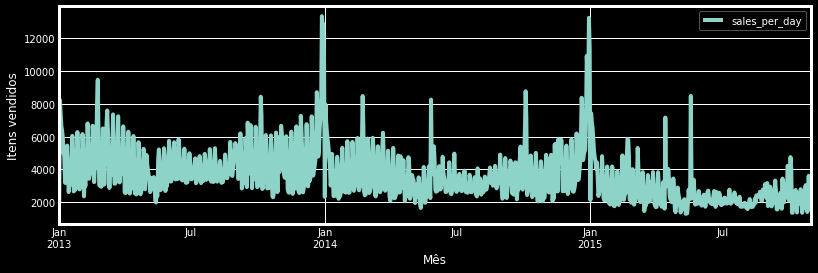

In [ ]:
with plt.style.context('dark_background'):
  sales_per_day['item_cnt_day'].plot(figsize=(12,4),legend=True)
  plt.legend(['sales_per_day'])
  plt.xlabel('Mês')
  plt.ylabel('Itens vendidos')

Nota-se um aumento exponencial nas vendas em dezembro, especialmente na semana do Natal.

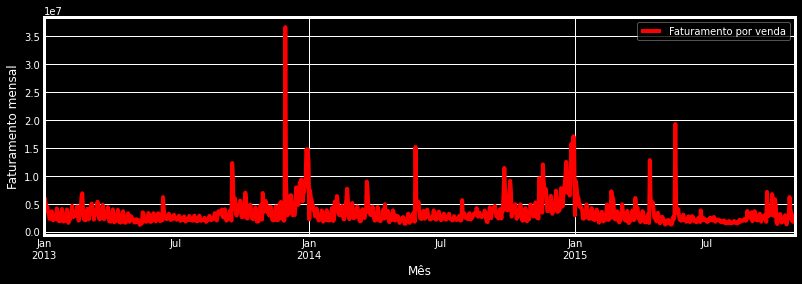

In [ ]:
with plt.style.context('dark_background'):
  sales_per_day['profit_per_sale'].plot(figsize=(12,4),legend=True,color='red')
  plt.legend(['Faturamento por venda'])
  plt.xlabel('Mês')
  plt.ylabel('Faturamento mensal')

Nota-se um momento excepcional na black friday de 2014 (última semana de novembro), o que não se repetiu posteriormente.

In [ ]:
item_per_day    = sales_per_day['item_cnt_day']
daily_invoicing = sales_per_day['profit_per_sale']

In [ ]:
item_per_day_train = item_per_day.iloc[:1031]
item_per_day_test  = item_per_day.iloc[1030:]
daily_invoicing_train = daily_invoicing.iloc[:1031]
daily_invoicing_test  = daily_invoicing.iloc[1030:]

In [ ]:
item_per_day_test.head()

date
2015-10-28    3599.0
2015-10-29    1591.0
2015-10-30    2277.0
2015-10-31    3107.0
Name: item_cnt_day, dtype: float64

Para teste do aprendizado da rede serão utilizados os últimos quatro dias do dataset.

**Gráfico de vendas por dia**: os itens em vermelho no final da série temporal são os itens de teste.

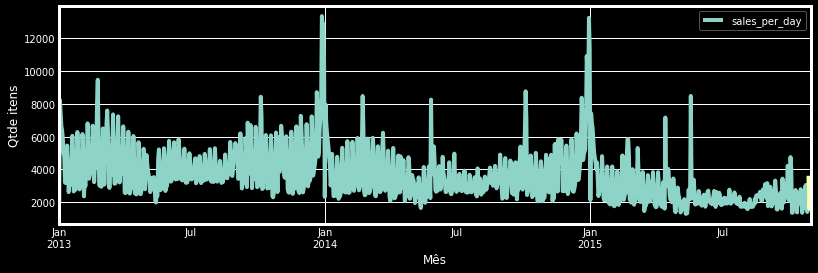

In [ ]:
with plt.style.context('dark_background'):
  item_per_day_train.plot(label=True,figsize=(12,4))
  item_per_day_test.plot(label =True,figsize=(12,4))
  plt.legend(['sales_per_day'])
  plt.xlabel('Mês')
  plt.ylabel('Qtde itens')
  plt.show()

**Faturamento por dia**: os itens em vermelho no final da série temporal são os itens de teste.

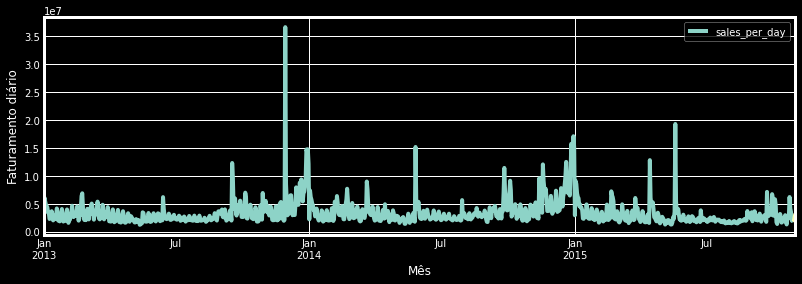

In [ ]:
with plt.style.context('dark_background'):
  daily_invoicing_train.plot(label=True,figsize=(12,4))
  daily_invoicing_test.plot(label =True,figsize=(12,4))
  plt.legend(['sales_per_day'])
  plt.xlabel('Mês')
  plt.ylabel('Faturamento diário')
  plt.show()

Definição dos datasets de treino e teste:

In [ ]:
profit_train_set = daily_invoicing_train.values
profit_test_set  = daily_invoicing_test.values
item_train_set   = item_per_day_train.values
item_test_set    =item_per_day_test.values

In [ ]:
profit_train_set = profit_train_set.reshape(-1,1)
profit_test_set  = profit_test_set.reshape(-1,1)
item_train_set   = item_train_set.reshape(-1,1)
item_test_set   = item_test_set.reshape(-1,1)

Ajuste de escala dos dados para treinamento de rede:

In [ ]:
sc = MinMaxScaler(feature_range=(0,1))

profit_train_set_norm = sc.fit_transform(profit_train_set)
profit_test_set_norm  = sc.transform(profit_test_set)

item_train_set_norm   = sc.fit_transform(item_train_set)
item_test_set_norm    = sc.transform(item_test_set)


In [ ]:
time_steps       = 2
n_samples_profit = profit_train_set_norm.size 
n_samples_item   = item_train_set_norm.size 
n_samples_profit_test = profit_test_set_norm.size 
n_samples_item_test  = item_test_set_norm.size
print("Número de amostras para treino:")
print(n_samples_profit,n_samples_item)
print("Número de amostras para teste:")
print(n_samples_profit_test,n_samples_item_test)

Número de amostras para treino:
1031 1031
Número de amostras para teste:
4 4


# **Treinamento da rede LSTM Multi-features**

In [ ]:
x_profit =[]
y_profit =[]

for i in range(time_steps,n_samples_profit):
  x_profit.append(profit_train_set_norm[i-time_steps:i,0])
  y_profit.append(profit_train_set_norm[i,0])

x_profit,y_profit = np.array(x_profit),np.array(y_profit)

In [ ]:
x_profit_test =[]
y_profit_test =[]

for i in range(time_steps,n_samples_profit_test):
  x_profit_test.append(profit_test_set_norm[i-time_steps:i,0])
  y_profit_test.append(profit_test_set_norm[i,0])

x_profit_test,y_profit_test = np.array(x_profit_test),np.array(y_profit_test)

In [ ]:
x_item =[]
y_item =[]

for i in range(time_steps,n_samples_item):
  x_item.append(item_train_set_norm[i-time_steps:i,0])
  y_item.append(item_train_set_norm[i,0])

x_item,y_item = np.array(x_item),np.array(y_item)

In [ ]:
x_item_test =[]
y_item_test =[]

for i in range(time_steps,n_samples_item_test):
  x_item_test.append(item_test_set_norm[i-time_steps:i,0])
  y_item_test.append(item_test_set_norm[i,0])

x_item_test,y_item_test = np.array(x_item_test),np.array(y_item_test)

In [ ]:
n_features =2 
train = np.array((x_item,x_profit))
train.shape
x_train_3D = np.reshape(train,(x_profit.shape[0],x_profit.shape[1],n_features))

x_train_3D.shape

(1029, 2, 2)

In [ ]:
n_features = 2
test = np.array((x_item_test,x_profit_test))
x_test_3D = np.reshape(test,(x_profit_test.shape[0],x_profit_test.shape[1],n_features))

x_test_3D.shape

(2, 2, 2)

In [ ]:
# Arquitetura LSTM
regressor = Sequential()

# Primeira camada LSTM com regularização dropout
regressor.add(LSTM(units=120, return_sequences=True, input_shape=( time_steps, n_features)))
regressor.add(Dropout(0.1))

# Segunda camada LSTM
regressor.add(LSTM(units=80))
regressor.add(Dropout(0.1))

# Camada de saída
regressor.add(Dense(units=1))

# Compilando a RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error',metrics=['mse','mae'])

# Fitting para os dados de treino
historico = regressor.fit(x_train_3D,y_item,epochs=20,batch_size=16,validation_data=(x_test_3D,y_item_test))

Epoch 1/20
65/65 [==============================] - 1s 18ms/step - loss: 0.0168 - mse: 0.0168 - mae: 0.0946 - val_loss: 0.0053 - val_mse: 0.0053 - val_mae: 0.0537
Epoch 2/20
65/65 [==============================] - 0s 7ms/step - loss: 0.0153 - mse: 0.0153 - mae: 0.0907 - val_loss: 0.0072 - val_mse: 0.0072 - val_mae: 0.0643
Epoch 3/20
65/65 [==============================] - 0s 6ms/step - loss: 0.0156 - mse: 0.0156 - mae: 0.0904 - val_loss: 0.0048 - val_mse: 0.0048 - val_mae: 0.0553
Epoch 4/20
65/65 [==============================] - 0s 6ms/step - loss: 0.0155 - mse: 0.0155 - mae: 0.0895 - val_loss: 0.0060 - val_mse: 0.0060 - val_mae: 0.0551
Epoch 5/20
65/65 [==============================] - 0s 6ms/step - loss: 0.0153 - mse: 0.0153 - mae: 0.0901 - val_loss: 0.0049 - val_mse: 0.0049 - val_mae: 0.0549
Epoch 6/20
65/65 [==============================] - 0s 7ms/step - loss: 0.0153 - mse: 0.0153 - mae: 0.0900 - val_loss: 0.0042 - val_mse: 0.0042 - val_mae: 0.0559
Epoch 7/20
65/65 [=========

Impressão do gráfico dos resultados do treinamento:

In [ ]:
print(historico.history.keys())

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


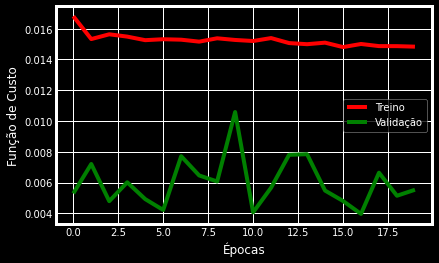

In [ ]:
with plt.style.context('dark_background'):
  plt.plot(historico.history['loss'],'r',label="Treino")
  plt.plot(historico.history['val_loss'],'g',label="Validação")
  plt.xlabel("Épocas")
  plt.ylabel("Função de Custo")
  plt.legend()

Nota-se que a função de custo de treino e de validação obtiveram valores muito satisfatórios, abaixo de 0.02.

# Prevendo para um dia específico do conjunto de teste:

In [ ]:
y_pred = regressor.predict(x_test_3D)

In [ ]:
y_pred_inverse_norm = sc.inverse_transform(y_pred)
print("Predição:")
print((y_pred_inverse_norm))
y_item_test = y_item_test.reshape(-1,1)
y_item_test_inverse_norm = sc.inverse_transform(y_item_test)
print("Real:")
print((y_item_test_inverse_norm))

Predição:
[[3510.1873]
 [2800.6445]]
Real:
[[2277.]
 [3107.]]


Apesar do baixo valor para a função de custo, especialmente de validação, a previsão do valor não é perfeita. 
Mudar os parâmetros de quantidade de neurônios, dropout, épocas ou batch_size não altera muito o resultado.
Inserir camadas de outros tipos de redes é uma opção viável para testar.